In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Detection_23Sep

/content/drive/MyDrive/Detection_23Sep


In [3]:
import os # importing OS in order to make GPU visible
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" # do not change anything in here

# specify which device you want to work on.
# Use "-1" to work on a CPU. Default value "0" stands for the 1st GPU that will be used
os.environ["CUDA_VISIBLE_DEVICES"]="0" # TODO: specify your computational device

In [4]:
import tensorflow as tf # import tensorflow

# checking that GPU is found
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

No GPU found


In [5]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from tqdm import tqdm

In [6]:
import sys # importyng sys in order to access scripts located in a different folder

path2scripts = 'models/research/' # TODO: provide pass to the research folder
sys.path.insert(0, path2scripts) # making scripts in models/research available for import

In [7]:
!pip install tf_slim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
!pip install tensorflow_io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
!pip install tf-models-official

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
# importing all scripts that will be needed to export your model and use it for inference
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

In [11]:
ls

Aug22smoke.mp4                         label_map.pbtxt
checkpoint/                            models/
Detection_23Sep_Inference_Final.ipynb  output.jpg
Detection_23Sep.ipynb                  pipeline.config
generate_tfrecord.py                   saved_model/
images/                                test.jpg
InferenceSignDetection.ipynb           Workspace/
istockphoto-462795637-612x612.jpg


In [12]:
# NOTE: your current working directory should be Tensorflow.

# TODO: specify two pathes: to the pipeline.config file and to the folder with trained model.
path2config ='/content/drive/MyDrive/Detection_23Sep/pipeline.config'
path2model = '/content/drive/MyDrive/Detection_23Sep/saved_model'

In [13]:
# do not change anything in this cell
configs = config_util.get_configs_from_pipeline_file(path2config) # importing config
model_config = configs['model'] # recreating model config
detection_model = model_builder.build(model_config=model_config, is_training=False) # importing model

In [14]:
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore('/content/drive/MyDrive/Detection_23Sep/checkpoint/ckpt-0').expect_partial()

In [15]:
path2label_map = '/content/drive/MyDrive/Detection_23Sep/label_map.pbtxt' # TODO: provide a path to the label map file
category_index = label_map_util.create_category_index_from_labelmap(path2label_map,use_display_name=True)

In [16]:
def detect_fn(image):
    """
    Detect objects in image.
    
    Args:
      image: (tf.tensor): 4D input image
      
    Returs:
      detections (dict): predictions that model made
    """

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    # print(detections)
    return detections

In [17]:

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      numpy array with shape (img_height, img_width, 3)
    """
    
    return np.array(Image.open(path))

In [18]:
from matplotlib import pyplot as plt
%matplotlib inline

def inference_with_plot(path2images, box_th=0.006):
    """
    Function that performs inference and plots resulting b-boxes
    
    Args:
      path2images: an array with pathes to images
      box_th: (float) value that defines threshold for model prediction.
      
    Returns:
      None
    """
    for image_path in path2images:

        # print('Running inference for {}... '.format(image_path), end='')

        image_np = load_image_into_numpy_array(image_path)
        
        input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
        detections = detect_fn(input_tensor)
        # print(type(detections))
        # All outputs are batches tensors.
        # Convert to numpy arrays, and take index [0] to remove the batch dimension.
        # We're only interested in the first num_detections.
        num_detections = int(detections.pop('num_detections'))
        detections = {key: value[0, :num_detections].numpy()
                      for key, value in detections.items()}
        # print(detections)
        
        
        detections['num_detections'] = num_detections

        # detection_classes should be ints.
        detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

        label_id_offset = 1
        image_np_with_detections = image_np.copy()

        viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=200,
                min_score_thresh=box_th,
                agnostic_mode=False,
                line_thickness=5)

        plt.figure(figsize=(15,10))
        plt.imshow(image_np_with_detections)
        plt.savefig('output.jpg')
        plt.show()
        # print('Done')

In [19]:
def nms(rects, thd=0.30):
    """
    Filter rectangles
    rects is array of oblects ([x1,y1,x2,y2], confidence, class)
    thd - intersection threshold (intersection divides min square of rectange)
    """
    out = []

    remove = [False] * len(rects)

    for i in range(0, len(rects) - 1):
        if remove[i]:
            continue
        inter = [0.0] * len(rects)
        for j in range(i, len(rects)):
            if remove[j]:
                continue
            inter[j] = intersection(rects[i][0], rects[j][0]) / min(square(rects[i][0]), square(rects[j][0]))

        max_prob = 0.0
        max_idx = 0
        for k in range(i, len(rects)):
            if inter[k] >= thd:
                if rects[k][1] > max_prob:
                    max_prob = rects[k][1]
                    max_idx = k

        for k in range(i, len(rects)):
            if (inter[k] >= thd) & (k != max_idx):
                remove[k] = True

    for k in range(0, len(rects)):
        if not remove[k]:
            out.append(rects[k])

    boxes = [box[0] for box in out]
    scores = [score[1] for score in out]
    classes = [cls[2] for cls in out]
    return boxes, scores, classes


def intersection(rect1, rect2):
    """
    Calculates square of intersection of two rectangles
    rect: list with coords of top-right and left-boom corners [x1,y1,x2,y2]
    return: square of intersection
    """
    x_overlap = max(0, min(rect1[2], rect2[2]) - max(rect1[0], rect2[0]));
    y_overlap = max(0, min(rect1[3], rect2[3]) - max(rect1[1], rect2[1]));
    overlapArea = x_overlap * y_overlap;
    return overlapArea


def square(rect):
    """
    Calculates square of rectangle
    """
    return abs(rect[2] - rect[0]) * abs(rect[3] - rect[1])

In [20]:
def inference_as_raw_output(path2images,
                            box_th = 0.30,
                            nms_th = 0.30,
                            to_file = False,
                            data = None,
                            path2dir = False):
    
    # print (f'Current data set is {data}')
    # print (f'Ready to start inference on {len(path2images)} images!')
    
    for image_path in tqdm(path2images):
        
        if path2dir: # if a path to a directory where images are stored was passed in
            image_path = os.path.join(path2dir, image_path.strip())
            
        image_np = load_image_into_numpy_array(image_path)

        input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
        detections = detect_fn(input_tensor)
        
        # checking how many detections we got
        num_detections = int(detections.pop('num_detections'))
        
        # filtering out detection in order to get only the one that are indeed detections
        detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
        
        # detection_classes should be ints.
        detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
        
        # defining what we need from the resulting detection dict that we got from model output
        key_of_interest = ['detection_classes', 'detection_boxes', 'detection_scores']
        
        # filtering out detection dict in order to get only boxes, classes and scores
        detections = {key: value for key, value in detections.items() if key in key_of_interest}
        
        if box_th: # filtering detection if a confidence threshold for boxes was given as a parameter
            for key in key_of_interest:
                scores = detections['detection_scores']
                current_array = detections[key]
                filtered_current_array = current_array[scores > box_th]
                detections[key] = filtered_current_array
        
        if nms_th: # filtering rectangles if nms threshold was passed in as a parameter
            # creating a zip object that will contain model output info as
            output_info = list(zip(detections['detection_boxes'],
                                   detections['detection_scores'],
                                   detections['detection_classes']
                                  )
                              )
            boxes, scores, classes = nms(output_info)
            
            detections['detection_boxes'] = boxes # format: [y1, x1, y2, x2]
            detections['detection_scores'] = scores
            detections['detection_classes'] = classes
            
        if to_file and data: # if saving to txt file was requested

            image_h, image_w, _ = image_np.shape
            file_name = f'pred_result_{data}.txt'
            #   print(file_name)
            line2write = list()
            line2write.append(os.path.basename(image_path))
            
            with open(file_name, 'a+') as text_file:
                # iterating over boxes
                for b, s, c in zip(boxes, scores, classes):
                    
                    y1abs, x1abs = b[0] * image_h, b[1] * image_w
                    y2abs, x2abs = b[2] * image_h, b[3] * image_w
                    
                    list2append = [x1abs, y1abs, x2abs, y2abs, s, c]
                    line2append = ','.join([str(item) for item in list2append])
                    
                    line2write.append(line2append)
                
                line2write = ' '.join(line2write)
                text_file.write(line2write + os.linesep)

        return detections

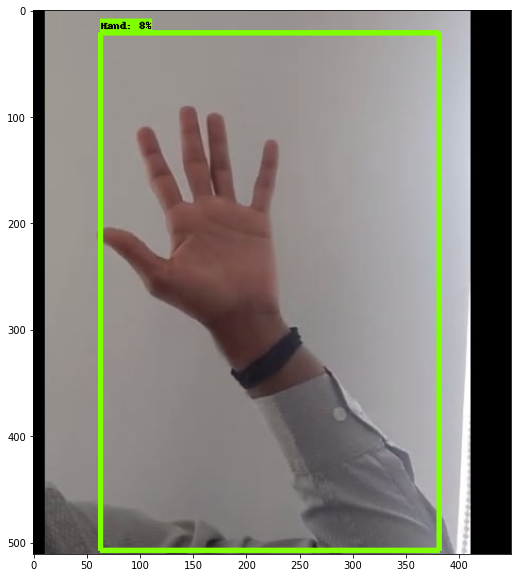

In [32]:
inference_with_plot(['/content/drive/MyDrive/Detection_23Sep/handscreenshot.jpg'],box_th=0.07)

In [22]:
import cv2
cv2.__version__

'4.5.2'

In [43]:
def inferencevideo(img, box_th=0.07):
    """
    Function that performs inference and plots resulting b-boxes
    
    Args:
      path2images: an array with pathes to images
      box_th: (float) value that defines threshold for model prediction.
      
    Returns:
      None
    """

    image_n = img
    image_np = cv2.cvtColor(image_n, cv2.COLOR_BGR2RGB)
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections
    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    # dc = detections['detection_classes']
    # print("Detection_class::::",dc)
    # classname = dc[0]
    # print("classDetection::",classname) 
    # print
    label_id_offset = 1
    image_np_with_detections = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=1,
                min_score_thresh=box_th,
                agnostic_mode=False,
                line_thickness=7)
    
    return image_np_with_detections

In [57]:
import cv2
img = cv2.imread('https://thumbs.dreamstime.com/b/open-hand-17041261.jpg')
f = inferencevideo(img, box_th=0.07)
# print("===========================\n",f)
plt.imshow(f)
# # font
# font = cv2.FONT_HERSHEY_SIMPLEX
# window_name = 'Image'
# # fontScale
# fontScale = 1
# org = (50, 50)

# # Blue color in BGR
# color = (255, 0, 0)
  
# # Line thickness of 2 px
# thickness = 2
   
# image = cv2.putText(img, str(f), org, font, 
#                    fontScale, color, thickness, cv2.LINE_AA)

# # plt.imshow(f)
# plt.imshow(image)

error: ignored

In [62]:

import gc
import time
def video():
  path = "/content/drive/MyDrive/Video/VID_20220926_092700.mp4" #input video path
  cap = cv2.VideoCapture(0)
  
  fram = cap.get(cv2.CAP_PROP_FRAME_COUNT) # number of frames in video

  fps = int(cap.get(cv2.CAP_PROP_FPS)) # frame rate of video
  vid = []
  k=0
  start_time = time.time()
  # print(fram)
  while(cap.isOpened()):
      ret, frame = cap.read()
      # frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
      if ret == False:
          # print("breaking...")
          break
      # print(frame.shape)    
      # print(k)
      k=k+1
      f = inferencevideo(frame,box_th=0.07)
      plt.imshow(f)
      plt.show()
      vid.append(f)
      if((k>= 1700)):
        break           
      gc.collect()
  # c = cv2.waitKey(1)
  cap.release()
  # cv2.destroyAllWindows()
  sec = (time.time() - start_time)
  # print("--- %s seconds ---" % sec ) #total time taken to process the video

  # print("saving video...")
  #saving output video locally
  #converting array to video
  size = (np.array(vid[0]).shape[0],np.array(vid[0]).shape[1]) #defining output video dimensions
  fps = 30 # fps defined for output video
  output_path = 'Aug22smoke.mp4' #full path of output video to be saved
  # print(output_path)
  out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'DIVX'), fps, (size[1], size[0]))
  for j in range(len(vid)):
      # print(j)
      img = vid[j]
      out.write(np.array(img))
  out.release()


In [63]:
import cv2
video()

IndexError: ignored